extensions to edit: .pdf, .txt, .docx

In [12]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/ApexioData/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

import numpy as np
import torch

import nltk
nltk.download('punkt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
# This is the big file so run this once to download to your drive
#!mkdir 'drive/My Drive/ApexioData/GloVe'
#!curl -Lo 'drive/My Drive/ApexioData/GloVe/glove.840B.300d.zip' http://nlp.stanford.edu/data/glove.840B.300d.zip
#!unzip 'drive/My Drive/ApexioData/GloVe/glove.840B.300d.zip' -d 'drive/My Drive/ApexioData/GloVe/'

In [15]:
# Run every time to download on the colab runtime
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

mkdir: cannot create directory ‘encoder’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  14.5M      0  0:00:10  0:00:10 --:--:-- 17.4M


In [0]:
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

"""
This file contains the definition of encoders used in https://arxiv.org/pdf/1705.02364.pdf
"""

import numpy as np
import time

import torch
import torch.nn as nn


class InferSent(nn.Module):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

        # keep only new words
        for word in self.word_vec:
            if word in word_dict:
                del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)

        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        import matplotlib.pyplot as plt
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        plt.xticks(x, sent[0], rotation=45)
        plt.bar(x, y)
        plt.ylabel('%')
        plt.title('Visualisation of words importance')
        plt.show()

        return output, idxs

In [17]:
# Load model

model_version = 1
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

model = model.cuda()

W2V_PATH = 'drive/My Drive/ApexioData/GloVe/glove.840B.300d.txt'
model.set_w2v_path(W2V_PATH)

model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [0]:
print(get_doc2vec('Hello new world. How are you doin'))

[ 0.1091588  -0.00877047 -0.00819609 ... -0.02699834 -0.03814263
  0.0350906 ]


In [0]:
!pip3 install textract

In [0]:
import textract

def extract(file_path):
    text = textract.process(file_path)
    return text.decode('utf-8')

In [0]:
import glob

farr = glob.glob(root_path + "testfiles/*")

In [0]:
import re
tarr = []
vecs = []
for f in farr:
  r = f.split(r'/testfiles/')[1]
  ext = r.split(r'.')[1]
  extr = extract(f)
  vecs.append(get_doc2vec(r))
  tarr.append([r, ext, extr, vecs[-1]])

print(tarr)

[['Copy of AMS 131 Quiz 1 Responses.docx', 'docx', 'AMS 131\n\nQuiz 1 Responses\n\nMax Alfano-Smith (ID 1684138)\n\n\n\nThis statement is Meaningless because something can’t have a probability that is a negative number.\n\nThis statement is True because if something has a probability of 0.8 its opposite has a probability of 0.2 and 0.8 is four times 0.2 so it is four times as likely to happen as its opposite.\n\n (i) is obviously a better option from an intuition standpoint because you are only reliant on one event happening, whereas (ii) requires the same event as (i)  to occur as well as an additional event, meaning (ii) will always be less likely then (i).\n\n\t(i) Probability :  \n\n(ii) Probability :  \n\n(ii) is a better choice from an intuitive standpoint because you are essentially betting on the same thing as (i), however you get a mulligan in the event that bet doesn’t work out.\n\n(i) Probability :  \n\n(ii) There are two possible probabilities in this case depending on if t

In [0]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [0]:
initial = tarr[0][3]
print(f'initial = {tarr[0][0]}')
for t in tarr:
  print(cosine(initial, t[3]),t[0])

initial = Copy of AMS 131 Quiz 1 Responses.docx
1.0000001 Copy of AMS 131 Quiz 1 Responses.docx
0.7624198 Copy of Writing 2 #17 Blog - Rough Draft.docx
0.9683681 Copy of AMS 131 Quiz 5 Responses.docx
0.9873122 Copy of AMS 131 Quiz 2 Responses.docx
0.9822319 Copy of AMS 131 Quiz 3 Responses.docx
0.97915804 Copy of AMS 131 Quiz 4 Responses.docx
0.9674914 Copy of AMS 131 Quiz 6 Responses.docx
0.9623627 Copy of AMS 131 Quiz 7 Responses.docx
0.96001863 Copy of AMS 131 Quiz 9 Responses.docx
0.9470624 Copy of AMS 131 Quiz 10 Responses.docx
0.96211 Copy of AMS 131 Quiz 8 Responses.docx
0.7871333 Copy of Writing 2 #18 Blog - Final Draft.docx
0.91894484 Copy of AMS 131 Test 1 Responses.docx
0.8865065 Copy of AMS 131 Test 2 Responses(1).docx
0.90783846 Copy of AMS 131 Test 3 Responses.docx
0.7995126 Copy of Writing 2 #11 Topic Exploration.docx
0.76722044 Copy of Writing 2 #15 Annotated Bibliography Responses.docx
0.9107957 Copy of AMS 131 Test 2 Responses.docx
0.7800787 Copy of Writing 2 #10 Rhet

In [20]:
from sklearn.cluster import KMeans
import nltk

def grab_file_names(path):
	files = []
	for r, d, f in os.walk(path):
		for file in f:
			files.append(os.path.join(r, file))
	return files

def K_means(n_clusters, big_dir):
  files = grab_file_names(big_dir)
  vecs = []
  names = []
  for f in files:
    name = f.split(r'/'+big_dir+'/')[1]
    print(name)
    names.append(name)
    vecs.append(get_doc2vec(name))
  clf = KMeans(n_clusters=n_clusters, 
              max_iter=1000, 
              init='k-means++', 
              n_init=1)
  labels = clf.fit_predict(vecs)
  sets = [[] for _ in range(n_clusters)]
  for i in range(len(names)):
    sets[labels[i]].append(names[i])
  return sets

print(K_means(2, 'drive/My Drive/ApexioData'))

Copy of Writing 2 #17 Blog - Rough Draft.docx
Copy of Writing 2 #18 Blog - Final Draft.docx
Copy of Writing 2 #11 Topic Exploration.docx
SNS1.docx
SNS2.docx
[['Copy of Writing 2 #17 Blog - Rough Draft.docx', 'Copy of Writing 2 #18 Blog - Final Draft.docx', 'Copy of Writing 2 #11 Topic Exploration.docx'], ['SNS1.docx', 'SNS2.docx']]


In [0]:
sets = [[] for _ in range(n_clusters)]
for i in range(len(tarr)):
  sets[labels[i]].append(tarr[i][0])
for s in sets:
  print(s)

['Copy of Writing 2 #17 Blog - Rough Draft.docx', 'Copy of Writing 2 #18 Blog - Final Draft.docx', 'Copy of Writing 2 #11 Topic Exploration.docx', 'Copy of Writing 2 #15 Annotated Bibliography Responses.docx', 'Copy of Writing 2 #10 Rhetorical Analysis on Kasser(1).docx', 'Copy of Writing 2 #15 Annotated Bibliography.docx', 'Copy of Writing 2 #10 Rhetorical Analysis on Kasser.docx', 'Copy of Writing 2 #19 Metacognition Reflection on Group Presentation.docx', 'Copy of Writing 2 #9 Rhetorical Analysis on Putnam(1).docx', 'Copy of Writing 2 First Essay Second Draft.docx', 'Copy of Writing 2 #9 Rhetorical Analysis on Putnam.docx', 'Copy of Writing 2 #8B Metacognition Reflection on Essay #1.docx']
['SNS1.docx', 'SNS2.docx', 'SNS3.docx', 'SNS4.docx']
['Copy of AMS 131 Quiz 1 Responses.docx', 'Copy of AMS 131 Quiz 5 Responses.docx', 'Copy of AMS 131 Quiz 2 Responses.docx', 'Copy of AMS 131 Quiz 3 Responses.docx', 'Copy of AMS 131 Quiz 4 Responses.docx', 'Copy of AMS 131 Quiz 6 Responses.docx'

In [0]:
stuff = glob.glob(root_path)
stuff

['drive/My Drive/ApexioData/']

In [0]:
import os
arr = os.listdir()
arr

['.config', 'encoder', 'drive', 'sample_data']

In [0]:
 def grab_files(path):
  files = []
  for r, d, f in os.walk(path):
      for file in f:
          files.append(os.path.join(r, file))

  return files

In [0]:
files = []
dirs = []
base_path = 'drive/My Drive/ApexioData/TestStuff/'
for r, d, f in os.walk(base_path):
  if len(d) != 0:
    dirs += d

print(dirs)

['AMS', 'CS70', 'Science', 'History', 'Core1', 'Crown92', 'WesternCiv', 'English', 'CollegeApps', 'Writing 2', 'debatedata']


In [0]:
import re
tarr = []
vecs = []
for i in range(len(dirs)):
  dir = dirs[i]
  print(dir)
  files = grab_files(base_path+dir+'/')
  for f in files:
    r = f.split(r'/'+dir+'/')[1]
    ext = r.split(r'.')[1]
    extr = extract(f)
    vecs.append(get_doc2vec(r))
    tarr.append([r, ext, extr, vecs[-1],i])

In [0]:
import random as rand
def generate_pairs(dat):
  pairs = []
  for i in range(len(dat)):
    for j in range(i+1,len(dat)):
      pairs.append((dat[i],dat[j]))
  return pairs

def generate_X_y_from_pairs(pairs):
  X = [[],[]]
  y = []
  for pair in pairs:
    X[0].append(pair[0][3])
    X[1].append(pair[1][3])
    y.append(1.0 if pair[0][4] == pair[1][4] else 0)
  return [np.array(x) for x in X], np.array(y)

def generate_X_y_from_dat(dat):
  X = [[],[]]
  y = []
  for i in range(len(dat)):
    for j in range(i+1,len(dat)):
      X[0].append(dat[i][3])
      X[1].append(dat[j][3])
      y.append(1.0 if dat[i][4] == dat[j][4] else 0)
  return [np.array(x) for x in X], np.array(y)

pairs = generate_pairs(tarr)
rand.shuffle(pairs)
train_pairs = pairs[:int(len(pairs) * 0.8)]
test_pairs = pairs[int(len(pairs) * 0.8):]
X_train, y_train = generate_X_y_from_pairs(train_pairs)
X_test, y_test = generate_X_y_from_pairs(test_pairs)

In [0]:
print(y_test)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]


In [0]:
import json
import nltk
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import random
from tensorflow.keras.layers import Input, Dense, Add, Dropout, Concatenate
from tensorflow.keras.models import Model
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import re
def get_dirs(path):
  dirs = []
  for r, d, f in os.walk(path):
    if len(d) != 0:
      dirs += d
  return dirs

def get_files(path, dirs):
  tarr = []
  vecs = []
  for i in range(len(dirs)):
    dir = dirs[i]
    print(dir)
    files = grab_files(path+dir+'/')
    for f in files:
      r = f.split(r'/'+dir+'/')[1]
      ext = r.split(r'.')[1]
      try:
        extr = extract(f)
        vecs.append(get_doc2vec(extr))
        tarr.append([r, ext, extr, vecs[-1],dir])
      except:
        print(f'File {r} not readable')
  return tarr

In [0]:
print(get_dirs(base_path))

['AMS', 'CS70', 'Science', 'History', 'Core1', 'Crown92', 'WesternCiv', 'English', 'CollegeApps', 'Writing 2', 'debatedata']


In [0]:
dirs = get_dirs('drive/My Drive/ApexioData/Archive/')
files_1 = get_files('drive/My Drive/ApexioData/Archive/',dirs)
dirs = get_dirs('drive/My Drive/ApexioData/TestStuff/')
files_2 = get_files('drive/My Drive/ApexioData/TestStuff/',dirs)
dirs = get_dirs('drive/My Drive/ApexioData/DylanData/')
files_3 = get_files('drive/My Drive/ApexioData/DylanData/',dirs)
print('Making Pairs')
pairs = generate_pairs(files_1 + files_2 + files_3)#pairs_1 + pairs_2
rand.shuffle(pairs)
train_pairs = pairs[:int(len(pairs) * 0.8)]
test_pairs = pairs[int(len(pairs) * 0.8):]
X_train, y_train = generate_X_y_from_pairs(train_pairs)
X_test, y_test = generate_X_y_from_pairs(test_pairs)
X_whole, X_whole = generate_X_y_from_pairs(pairs)
whole_pairs = pairs

Cornell
APUSH
Resume
bioe100 final
bio
AMS
CS70
Science
History
Core1
Crown92
WesternCiv
English
File Archetypal Narrative Packet.doc not readable
File ATSS Quick Write.doc not readable
File Sashimi Cashmere.doc not readable
File Root Practice.doc not readable
File Identity Project Visual copy.jpg not readable
File Root Practice Student.doc not readable
CollegeApps
Writing 2
debatedata
File 340824.pdf not readable
File jlf71019.pdf not readable
Phil 11
Phil 8
Stev Core 1
Stev 26
Making Pairs


In [0]:
input_1 = Input((4096,), dtype=tf.float32)
input_2 = Input((4096,), dtype=tf.float32)
reduce_dim_1 = Dense(1000, activation='relu')
con = Concatenate()([reduce_dim_1(input_1),reduce_dim_1(input_2)])
x_1 = Dense(1000, activation='relu')(con)
x_2 = Dense(500, activation='relu')(x_1)
x_3 = Dense(100, activation='relu')(x_2)
x_4 = Dense(25, activation='relu')(x_3)
out = Dense(1, activation='sigmoid')(x_4)
dual_model = Model(inputs=[input_1, input_2], outputs=out) 
dual_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
dual_model.fit(X_train, y_train, epochs=10)#,validation_split=0.2)

Train on 36120 samples
Epoch 1/10
36120/36120 [==============================] - 6s 176us/sample - loss: 0.1865 - acc: 0.9318
Epoch 2/10
36120/36120 [==============================] - 6s 175us/sample - loss: 0.0886 - acc: 0.9643
Epoch 3/10
36120/36120 [==============================] - 6s 177us/sample - loss: 0.0510 - acc: 0.9804
Epoch 4/10
36120/36120 [==============================] - 6s 179us/sample - loss: 0.0366 - acc: 0.9872
Epoch 5/10
36120/36120 [==============================] - 7s 181us/sample - loss: 0.0275 - acc: 0.9906
Epoch 6/10
36120/36120 [==============================] - 7s 183us/sample - loss: 0.0225 - acc: 0.9927
Epoch 7/10
36120/36120 [==============================] - 6s 175us/sample - loss: 0.0191 - acc: 0.9935
Epoch 8/10
36120/36120 [==============================] - 6s 179us/sample - loss: 0.0247 - acc: 0.9913
Epoch 9/10
36120/36120 [==============================] - 6s 179us/sample - loss: 0.0252 - acc: 0.9913
Epoch 10/10
36120/36120 [=========================

In [0]:
dual_model.evaluate(X_test, y_test)

9030/9030 [==============================] - 1s 94us/sample - loss: 0.0168 - acc: 0.9940


[0.01675312447191215, 0.9940199]

In [0]:
correct = 0
for pair in test_pairs:
  X, y = generate_X_y_from_pairs([pair])
  ev = round(np.sum(dual_model.predict(X)))
  #print(pair[0][0] + ' -- ' + pair[1][0] + ' --', ev)
  correct += 1 if ev == y[0] else 0
print(correct / len(test_pairs))

0.9880398671096345


In [0]:
dirs = get_dirs('drive/My Drive/ApexioData/TestStuff2/')
files_1 = get_files('drive/My Drive/ApexioData/TestStuff2/',dirs)
test_pairs_2 = generate_pairs(files_1)
rand.shuffle(test_pairs_2)
X_test_2, y_test_2 = generate_X_y_from_pairs(test_pairs_2)

Birthday
xmas
Drama


In [0]:
dual_model.evaluate(X_test_2,y_test_2)

171/171 [==============================] - 0s 129us/sample - loss: 1.6721 - acc: 0.6667


[1.672113857771221, 0.6666667]

In [0]:
correct = 0
for pair in test_pairs_2:
  X, y = generate_X_y_from_pairs([pair])
  ev = round(np.sum(dual_model.predict(X)))
  correct += 1 if ev == y[0] else 0
  #if y[0] != ev:
    #print(pair[0][0] + ' -- ' + pair[1][0] + ' --', ev)
print(correct / len(test_pairs_2))

0.49707602339181284


In [0]:
!pip3 install networkX

In [0]:
import networkx as nx

In [0]:
def generate_graph(pairs):
  g = nx.Graph()
  X, y = generate_X_y_from_pairs(pairs)
  out = dual_model.predict(X)
  for i in range(len(pairs)):
    if out[i][0] > 0.5:
      g.add_edge(pairs[i][0][0], pairs[i][1][0])
    else:
      g.add_node(pairs[i][0][0])
      g.add_node(pairs[i][1][0])
  return g

In [0]:
g = generate_graph(whole_pairs)

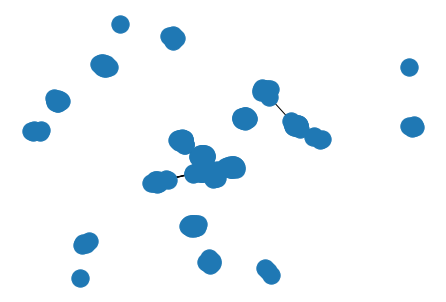

In [0]:
import matplotlib.pyplot as plt
nx.draw(g)

In [0]:
for c in nx.connected_components(g):
  print(c)

{'ATSS Blog Post 2 V2.docx', 'Copy of APUSH DBQ1 Prep.docx', "A Room of One's Own Chapters 3 and 6 Reading Notes.docx", 'Lession 23.docx', 'Brooks BN Neg 4.docx', 'Genesis Reading Notes.docx', 'Diplomacy Definitions.docx', 'Body Paragraph Practice.docx', 'Absolute Monarch Interview.docx', 'Voltaire Research Paper Rough Draft.docx', 'Communist Manifesto Part 1 & 2 Reading Notes.docx', "Olivia's Study Guide.docx", 'Ch. 5 Discussion and Creative Writing.docx', 'Paradigm Shift Paragraph.docx', 'American Sniper Analysis.docx', 'Frq Re-wrte #2 APUSH.docx', 'Brooks BN Foundation Blocks.docx', 'Civil Disobedience Reading Notes.docx', 'Apush essay redo.docx', 'Kehler - Core Essay Topic I.pdf', 'Macbeth Act 2-3 Reading Guide.docx', 'PostWWIIdomesticpolicyquestions.doc.docx', 'Serial Essay Rough Draft.docx', 'Industrialization Essay.docx', 'Diplomacy England Research.docx', 'Second Essay Rough Draft.docx', 'First Essay Brain Storm.docx', '20032043.pdf', 'Brooks BN Nats Neg 2.docx', 'Proggressive 

In [0]:
g.order()

301

In [0]:
dual_model.deploy_model(description='Keras Dual Input Data Organization Model',
            author="Maximillian Alfano-Smith and Roanak Baviskar", organisation='Apexio',
            file_name='dual_model.sav')

In [0]:
dual_model.save('Model.pickle')